In [61]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [62]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

df = read_excel('lstm_dmc.xlsx')

In [63]:
df.head()

,Date,Affected
0,2019/09/01,92.0
1,2019/09/02,82.0
2,2019/09/03,64.0
3,2019/09/04,47.0
4,2019/09/05,63.0


In [64]:
df.shape

(698, 2)

In [65]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].values.astype(float)
df = df[df['Affected'].notnull()]

In [66]:
def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples


window_size = 14
samples = create_time_series_samples(df, window_size)

In [67]:
samples[0].head(11)

,Date,Affected
0,1.567296e+18,92.0
1,1.567382e+18,82.0
2,1.567469e+18,64.0
3,1.567555e+18,47.0
4,1.567642e+18,63.0
5,1.567728e+18,61.0
6,1.567814e+18,33.0
7,1.567901e+18,52.0
8,1.568074e+18,81.0
9,1.568160e+18,49.0


In [68]:
affected_df = pd.DataFrame([sample['Affected'].values for sample in samples])
affected_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,92.0,82.0,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0
1,82.0,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0
2,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0
3,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0
4,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0


In [69]:
affected_df.shape

(674, 14)

In [70]:
#split in train and test
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(affected_df, 0.8, False)

In [71]:
test_df.shape

(135, 14)

In [72]:
train_df.shape

(539, 14)

In [73]:
def split_X_y(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [74]:
print(X_train.shape)
print(y_train.shape)

(539, 13)
(539,)


In [75]:
print(X_test.shape)
print(y_test.shape)

(135, 13)
(135,)


In [76]:
print("X-train shape: ", X_train.shape)
print("y-train shape: ", y_train.shape)
print("X-test shape: ", X_test.shape)
print("y-test shape: ", y_test.shape)

X-train shape:  (539, 13)
y-train shape:  (539,)
X-test shape:  (135, 13)
y-test shape:  (135,)


In [77]:
def get_train_test_loader(X_train, y_train, X_test, y_test, batch_size):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)

    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, X_test_tensor, y_test_tensor


In [78]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  
        return out

In [79]:
def initialize_the_model(input_size,hidden_size,num_layers):
    model = LSTMModel(input_size, hidden_size, num_layers)
    return model

def get_loss_and_optimizer(model, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return criterion, optimizer

In [80]:
def train(model, criterion, optimizer, train_loader, num_epochs):
    train_losses = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        train_losses[epoch] = loss.item()

    return train_losses

In [81]:
def pred(model, criterion, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor.unsqueeze(1))
        test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
        print(f'Test Loss: {test_loss.item():.4f}')

    predictions = test_outputs.numpy()
    return predictions

In [82]:
def plot_predictions(y_test, predictions):
    y_test = y_test.reset_index(drop=True)
    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.show()

In [83]:
def plot_loss(train_losses):
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training loss')
    plt.legend()
    plt.show()

In [84]:
# define hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32

In [85]:
train_loader, test_loader, X_test_tensor, y_test_tensor = get_train_test_loader(X_train, y_train, X_test, y_test, batch_size)
model = initialize_the_model(window_size-1, 50, 1)
criterion, optimizer = get_loss_and_optimizer(model, learning_rate)
train_losses = train(model, criterion, optimizer, train_loader, num_epochs)
predictions = pred(model, criterion, X_test_tensor, y_test_tensor)

Epoch [1/500], Loss: 634.9304
Epoch [2/500], Loss: 427.6760
Epoch [3/500], Loss: 287.1616
Epoch [4/500], Loss: 379.1653
Epoch [5/500], Loss: 223.9565
Epoch [6/500], Loss: 213.1893
Epoch [7/500], Loss: 724.8768


Epoch [8/500], Loss: 344.9822
Epoch [9/500], Loss: 255.3491
Epoch [10/500], Loss: 256.1718
Epoch [11/500], Loss: 249.5982
Epoch [12/500], Loss: 157.4089
Epoch [13/500], Loss: 322.4935
Epoch [14/500], Loss: 238.5996
Epoch [15/500], Loss: 433.3015
Epoch [16/500], Loss: 547.3508
Epoch [17/500], Loss: 1078.9127
Epoch [18/500], Loss: 165.4341
Epoch [19/500], Loss: 404.0046
Epoch [20/500], Loss: 551.7432
Epoch [21/500], Loss: 157.9410
Epoch [22/500], Loss: 307.6106
Epoch [23/500], Loss: 320.3033
Epoch [24/500], Loss: 83.2813
Epoch [25/500], Loss: 238.8996
Epoch [26/500], Loss: 497.1732
Epoch [27/500], Loss: 213.6742
Epoch [28/500], Loss: 79.6404
Epoch [29/500], Loss: 97.4368
Epoch [30/500], Loss: 143.4432
Epoch [31/500], Loss: 298.4580
Epoch [32/500], Loss: 981.6883
Epoch [33/500], Loss: 27.9846
Epoch [34/500], Loss: 214.7588
Epoch [35/500], Loss: 83.4597
Epoch [36/500], Loss: 296.5011
Epoch [37/500], Loss: 299.3764
Epoch [38/500], Loss: 138.1464
Epoch [39/500], Loss: 257.2343
Epoch [40/500]

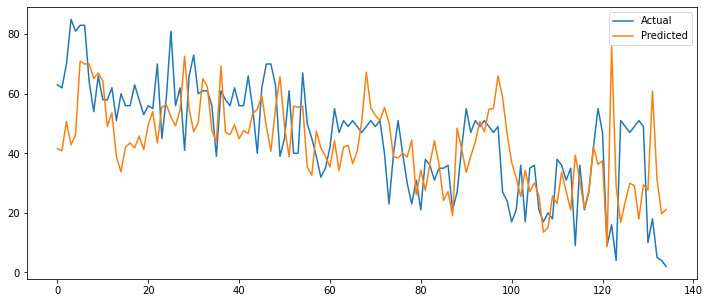

In [86]:
plot_predictions(y_test, predictions)

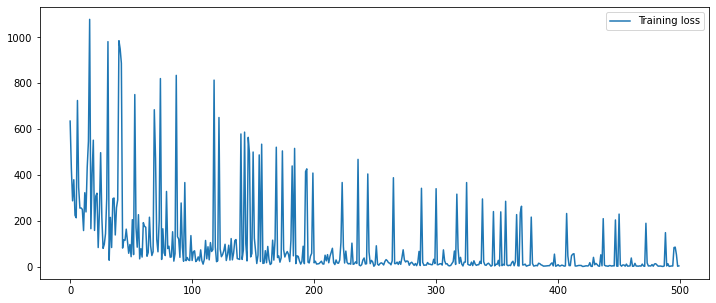

In [87]:
plot_loss(train_losses)

In [88]:
y_test.shape

(135,)

In [89]:
train_losses

array([6.34930420e+02, 4.27675964e+02, 2.87161560e+02, 3.79165283e+02,
       2.23956482e+02, 2.13189346e+02, 7.24876831e+02, 3.44982178e+02,
       2.55349060e+02, 2.56171814e+02, 2.49598236e+02, 1.57408905e+02,
       3.22493530e+02, 2.38599594e+02, 4.33301483e+02, 5.47350830e+02,
       1.07891272e+03, 1.65434143e+02, 4.04004639e+02, 5.51743164e+02,
       1.57940994e+02, 3.07610626e+02, 3.20303345e+02, 8.32813110e+01,
       2.38899612e+02, 4.97173248e+02, 2.13674210e+02, 7.96403656e+01,
       9.74367981e+01, 1.43443176e+02, 2.98458038e+02, 9.81688293e+02,
       2.79846458e+01, 2.14758804e+02, 8.34597473e+01, 2.96501129e+02,
       2.99376373e+02, 1.38146393e+02, 2.57234283e+02, 2.91662384e+02,
       9.85721863e+02, 9.50402039e+02, 8.87364136e+02, 8.09016037e+01,
       1.16823730e+02, 1.14793320e+02, 1.63565491e+02, 1.10362648e+02,
       5.82225113e+01, 9.64976425e+01, 4.33452110e+01, 2.04872498e+02,
       5.24532242e+01, 7.50789429e+02, 1.69807129e+02, 8.48370590e+01,
      